# Gradient Boosting

In [1]:
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
import bz2
import os
import sys
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy as sp
import seaborn as sns
from IPython.display import display
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

sys.path.append(os.path.abspath('../src'))
from fact_classification import *

2023-04-17 22:07:47.934429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load datafiles

In [3]:
df, df_crowdsourced, df_ground_truth = data_loading(local=True)
df['Sentiment'] = df.Sentiment.fillna(df.Sentiment[df.Verdict == -1].mean())

## Load features
Load the features matrix that we generated in the `feature_generation.ipynb` notebook. This is a large sparse matrix so ww convert it to Compressed Sparse Row (CSR) format to avoid running out of memory when fitting our models.

In [4]:
with bz2.open('../results/df_features.bz2') as f:
    df_features = pickle.load(f)

# Convert to compressed sparse row matrix
csr_features = sp.sparse.csr_matrix(df_features)

## Split data and generate indexes

We split the dataset according to the instructions in the assignment, where data up until and including year 2008 will be used for training, and data after 2008 will be used for testing. Here we also generate indexes for the various feature sets.

In [5]:
df_train, df_test, idx_train = test_train_split(df)

csr_features_train = csr_features[idx_train]
csr_features_test = csr_features[~idx_train]

# Column index for the numeric columns Sentiment and Length
col_idx_n = (df_features.columns == 'Sentiment') | (df_features.columns == 'Length')

# Column index for TF-IDF features on the raw Text column with n-grams=1
col_idx_w1 = df_features.columns.str.startswith('W1_')

# Column index for TF-IDF features on the raw Text column with n-grams=2
col_idx_w2 = df_features.columns.str.startswith('W2_')

# Column index for TF-IDF features on the stemmed text with n-grams=1
col_idx_ws = df_features.columns.str.startswith('WS_')

# Column index for POS features
col_idx_p = df_features.columns.str.startswith('P_')

# Column index for NER labels
col_idx_e = df_features.columns.str.startswith('E_')

## Setup for GridSearchCV

In [6]:
gbc = GradientBoostingClassifier(
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.1, 0.5]
}

clf = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=4,
    n_jobs=-1,
    return_train_score=True,
    verbose=0
)


## Define experiments

In [7]:
# Define experiments
experiments = {
    'N': col_idx_n,
    'W': col_idx_w1,
    'P': col_idx_p,
    'E': col_idx_e,
    'N_W': col_idx_n | col_idx_w1,
    'N_P': col_idx_n | col_idx_p,
    'N_E': col_idx_n | col_idx_e,
    'N_W_P': col_idx_n | col_idx_w1 | col_idx_p,
    'N_W_E': col_idx_n | col_idx_w1 | col_idx_e,
    'N_W_P_E': col_idx_n | col_idx_w1 | col_idx_p | col_idx_e
}


## Run experiments

In [8]:
df_score_train = pd.DataFrame()
df_score_test = pd.DataFrame()
models = {}

for features, index in experiments.items():
  exp_clf, exp_score_train, exp_score_test = run_experiment(
      clf=clf,
      X_train=csr_features_train[:, index],
      y_train=df_train['Verdict'],
      X_test=csr_features_test[:, index],
      y_test=df_test['Verdict'],
      annotations={
        'algorithm': 'GB',
        'features': features}
  )
  models[features] = exp_clf
  # Print test results
  print('Test metrics:')
  display(exp_score_test)
  # Add results to dataframe
  df_score_train = pd.concat([df_score_train, exp_score_train]).reset_index(drop=True)
  df_score_test = pd.concat([df_score_test, exp_score_test]).reset_index(drop=True)

Running experiment with algorithm "GBC" and features "N"
Best parameters found: {'learning_rate': 0.5, 'n_estimators': 400}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,N,0.627,0.07,0.379,0.496,0.914,0.021,0.092,0.591,0.744,0.032,0.148,0.503


Running experiment with algorithm "GBC" and features "W"
Best parameters found: {'learning_rate': 0.5, 'n_estimators': 400}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,W,0.73,0.405,0.675,0.678,0.92,0.225,0.397,0.7,0.814,0.289,0.5,0.67


Running experiment with algorithm "GBC" and features "P"
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 400}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,P,0.715,0.379,0.573,0.638,0.919,0.098,0.378,0.68,0.804,0.156,0.455,0.636


Running experiment with algorithm "GBC" and features "E"
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 200}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,E,0.674,0.273,0.683,0.63,0.962,0.005,0.3,0.675,0.793,0.009,0.417,0.602


Running experiment with algorithm "GBC" and features "N_W"
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 400}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,N_W,0.712,0.512,0.742,0.697,0.962,0.172,0.353,0.708,0.819,0.257,0.479,0.663


Running experiment with algorithm "GBC" and features "N_P"
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 200}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,N_P,0.714,0.378,0.591,0.642,0.931,0.112,0.355,0.682,0.808,0.173,0.443,0.637


Running experiment with algorithm "GBC" and features "N_E"
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 200}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,N_E,0.677,0.357,0.695,0.644,0.959,0.016,0.31,0.677,0.793,0.031,0.429,0.608


Running experiment with algorithm "GBC" and features "N_W_P"
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 400}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,N_W_P,0.741,0.502,0.696,0.701,0.942,0.228,0.423,0.721,0.83,0.313,0.526,0.689


Running experiment with algorithm "GBC" and features "N_W_E"
Best parameters found: {'learning_rate': 0.5, 'n_estimators': 400}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,N_W_E,0.738,0.404,0.662,0.679,0.91,0.231,0.429,0.703,0.815,0.294,0.521,0.676


Running experiment with algorithm "GBC" and features "N_W_P_E"
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 400}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,GBC,N_W_P_E,0.744,0.504,0.728,0.712,0.951,0.222,0.436,0.729,0.835,0.308,0.546,0.697


# Results

In [9]:
print('Training metrics:')
display(df_score_train.sort_values(by='f_wavg', ascending=False))

print('Testing metrics:')
display(df_score_test.sort_values(by='f_wavg', ascending=False))

Training metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
8,GBC,N_W_E,0.981,0.989,0.978,0.981,0.998,0.913,0.964,0.981,0.989,0.950,0.971,0.981
1,GBC,W,0.976,0.992,0.979,0.978,0.998,0.909,0.950,0.978,0.987,0.948,0.964,0.978
9,GBC,N_W_P_E,0.852,0.862,0.822,0.846,0.966,0.389,0.705,0.847,0.906,0.536,0.759,0.834
7,GBC,N_W_P,0.849,0.849,0.820,0.842,0.966,0.385,0.692,0.844,0.904,0.530,0.751,0.830
4,GBC,N_W,0.824,0.866,0.862,0.837,0.979,0.335,0.627,0.832,0.895,0.483,0.726,0.814
2,GBC,P,0.816,0.761,0.686,0.780,0.941,0.228,0.594,0.788,0.874,0.351,0.637,0.766
0,GBC,N,0.772,0.990,0.885,0.821,0.986,0.371,0.424,0.793,0.866,0.540,0.574,0.765
5,GBC,N_P,0.807,0.661,0.666,0.760,0.938,0.181,0.568,0.775,0.868,0.284,0.613,0.749
6,GBC,N_E,0.755,0.738,0.692,0.738,0.951,0.049,0.458,0.745,0.841,0.092,0.551,0.698
3,GBC,E,0.743,0.837,0.683,0.738,0.952,0.022,0.422,0.735,0.835,0.043,0.521,0.681


Testing metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
9,GBC,N_W_P_E,0.744,0.504,0.728,0.712,0.951,0.222,0.436,0.729,0.835,0.308,0.546,0.697
7,GBC,N_W_P,0.741,0.502,0.696,0.701,0.942,0.228,0.423,0.721,0.830,0.313,0.526,0.689
8,GBC,N_W_E,0.738,0.404,0.662,0.679,0.910,0.231,0.429,0.703,0.815,0.294,0.521,0.676
1,GBC,W,0.730,0.405,0.675,0.678,0.920,0.225,0.397,0.700,0.814,0.289,0.500,0.670
4,GBC,N_W,0.712,0.512,0.742,0.697,0.962,0.172,0.353,0.708,0.819,0.257,0.479,0.663
5,GBC,N_P,0.714,0.378,0.591,0.642,0.931,0.112,0.355,0.682,0.808,0.173,0.443,0.637
2,GBC,P,0.715,0.379,0.573,0.638,0.919,0.098,0.378,0.680,0.804,0.156,0.455,0.636
6,GBC,N_E,0.677,0.357,0.695,0.644,0.959,0.016,0.310,0.677,0.793,0.031,0.429,0.608
3,GBC,E,0.674,0.273,0.683,0.630,0.962,0.005,0.300,0.675,0.793,0.009,0.417,0.602
0,GBC,N,0.627,0.070,0.379,0.496,0.914,0.021,0.092,0.591,0.744,0.032,0.148,0.503


## Feature Importance

In [10]:
best_features = df_score_test.sort_values(by='f_wavg', ascending=False).reset_index().loc[0, 'features']
best_features_idx = experiments[best_features]
best_model = models[best_features].best_estimator_


In [11]:
# Average feature importance
df_feature_importance = pd.DataFrame({
    'Feature': df_features.columns[best_features_idx],
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)
df_feature_importance.reset_index(inplace=True, drop=True)
df_feature_importance.head(10)


,Feature,Importance
0,P_VBD,0.168298
1,P_VB,0.083870
2,E_money,0.065715
3,E_percent,0.044980
4,P_NNP,0.036371
5,E_date,0.032753
6,E_cardinal,0.032297
7,Sentiment,0.028562
8,P_VBN,0.027172
9,P_VBP,0.016177


### Plot feature importance

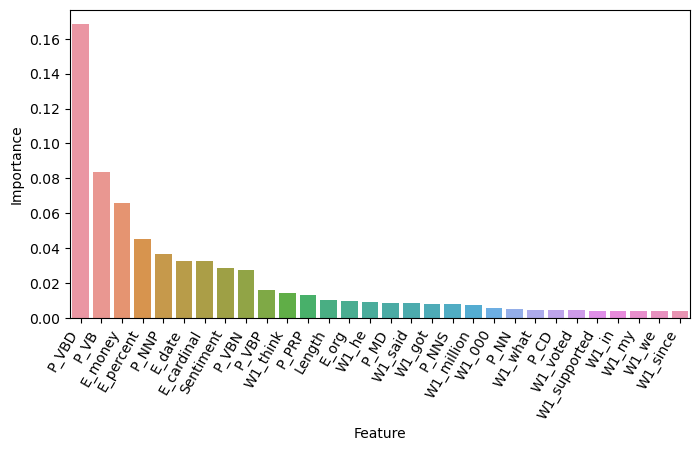

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_feature_importance.head(30), x='Feature', y='Importance', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
plt.show()

## Save results to file

In [13]:
# Save the scoring metrics to file
score_saving(df_score_train, df_score_test, fname='GradientBoosting_score')

# Save the trained models to file
with bz2.open('../models/GradientBoosting.bz2', 'wb') as f:
    pickle.dump(models, f)

## Export results to LaTeX

In [14]:
to_latex(df_score_train)

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
GBC & N & 0.772 & 0.990 & 0.885 & 0.821 & 0.986 & 0.371 & 0.424 & 0.793 & 0.866 & 0.540 & 0.574 & 0.765 \\
GBC & W & 0.976 & 0.992 & 0.979 & 0.978 & 0.998 & 0.909 & 0.950 & 0.978 & 0.987 & 0.948 & 0.964 & 0.978 \\
GBC & P & 0.816 & 0.761 & 0.686 & 0.780 & 0.941 & 0.228 & 0.594 & 0.788 & 0.874 & 0.351 & 0.637 & 0.766 \\
GBC & E & 0.743 & 0.837 & 0.683 & 0.738 & 0.952 & 0.022 & 0.422 & 0.735 & 0.835 & 0.043 & 0.521 & 0.681 \\
GBC & N\_W & 0.824 & 0.866 & 0.862 & 0.837 & 0.979 & 0.335 & 0.627 & 0.832 & 0.895 & 0.483 & 0.726 & 0.814 \\
GBC & N\_P & 0.807 & 0.661 & 0.666 & 0.760 & 0.938 & 0.181 & 0.568 & 0.775 & 0.868 & 0.284 & 0.613 & 0.749 \\
GBC & N\_E & 0.755 & 0.738 & 0.692 & 0.738 & 0.951 & 0.049 & 0.458 & 0.745 & 0.841 & 0.092 & 0.551 & 0.698 \\
GBC & N\_W\_P & 0.849 & 0.849 & 0.820 & 0.842 & 0.966 & 0

In [15]:
to_latex(df_score_test)

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
GBC & N & 0.627 & 0.070 & 0.379 & 0.496 & 0.914 & 0.021 & 0.092 & 0.591 & 0.744 & 0.032 & 0.148 & 0.503 \\
GBC & W & 0.730 & 0.405 & 0.675 & 0.678 & 0.920 & 0.225 & 0.397 & 0.700 & 0.814 & 0.289 & 0.500 & 0.670 \\
GBC & P & 0.715 & 0.379 & 0.573 & 0.638 & 0.919 & 0.098 & 0.378 & 0.680 & 0.804 & 0.156 & 0.455 & 0.636 \\
GBC & E & 0.674 & 0.273 & 0.683 & 0.630 & 0.962 & 0.005 & 0.300 & 0.675 & 0.793 & 0.009 & 0.417 & 0.602 \\
GBC & N\_W & 0.712 & 0.512 & 0.742 & 0.697 & 0.962 & 0.172 & 0.353 & 0.708 & 0.819 & 0.257 & 0.479 & 0.663 \\
GBC & N\_P & 0.714 & 0.378 & 0.591 & 0.642 & 0.931 & 0.112 & 0.355 & 0.682 & 0.808 & 0.173 & 0.443 & 0.637 \\
GBC & N\_E & 0.677 & 0.357 & 0.695 & 0.644 & 0.959 & 0.016 & 0.310 & 0.677 & 0.793 & 0.031 & 0.429 & 0.608 \\
GBC & N\_W\_P & 0.741 & 0.502 & 0.696 & 0.701 & 0.942 & 0